In [12]:
import matplotlib.pyplot as plt
import numpy as np
from qiskit_algorithms.optimizers import COBYLA, L_BFGS_B
from qiskit_algorithms.utils import algorithm_globals
from qiskit import Aer
from squlearn import Executor
from squlearn.observables import IsingHamiltonian
from squlearn.qnn import QNNRegressor, SquaredLoss
from squlearn.optimizers import SLSQP, Adam, SPSA
from squlearn.observables import SummedPaulis
from squlearn.qnn import QNNRegressor, SquaredLoss
from squlearn.optimizers import Adam
from squlearn import Executor
from squlearn import Executor
from squlearn.encoding_circuit import HubregtsenEncodingCircuit
from squlearn.kernel.matrix import ProjectedQuantumKernel
from squlearn.kernel.matrix import FidelityKernel
from squlearn.kernel.ml import QGPR
from squlearn.kernel.ml.qsvr import QSVR

from qiskit.circuit.library import TwoLocal
from squlearn.encoding_circuit import *

algorithm_globals.random_seed = 42



In [13]:
# Function to read and process data from the input format
def read_data(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()

    features = []
    labels = []

    i = 0
    while i < 2000:
        num_atoms = int(lines[i])
        energy = float(lines[i + 1].split()[-1])
        label = np.array([energy])

        atom_data = [line.split() for line in lines[i + 2:i + 2 + num_atoms]]
        coordinates = np.array([[float(coord) for coord in atom[1:]] for atom in atom_data])

        features.append(coordinates.flatten())
        labels.append(label)

        i += 2 + num_atoms

    return np.array(features), np.array(labels)


# Read data from the provided file
file_path = 'water-DZ-F12-STATIC-g32n10-3M_PES-DZERO.xyz'
features, labels = read_data(file_path)
print(features[3], labels[3])
print(len(features), len(labels))

[ 0.02860095  0.          0.43550962 -0.95333518  0.         -0.71874285
  0.49941735  0.         -0.36650326] [-76.24559204]
400 400


In [14]:
from sklearn.model_selection import train_test_split
from qiskit_algorithms.utils import algorithm_globals
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA

features = MinMaxScaler().fit_transform(features)

train_labelm = np.mean(labels)
train_labelstd = np.std(labels)

print("Mean = ", train_labelm, "Std =", train_labelstd)

transformed_labels = (labels - train_labelm) / train_labelstd
print(len(transformed_labels))
print(transformed_labels[1])

test_size=0.25
algorithm_globals.random_seed = 123
train_features, test_features, train_labels, test_labels = train_test_split(
    features, transformed_labels, train_size=0.75, random_state=algorithm_globals.random_seed
)


Mean =  -76.1244452830175 Std = 0.09935006498137963
400
[-1.50425506]


In [15]:
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [16]:
encoding_circuit = HubregtsenEncodingCircuit(num_qubits=3, num_features=9, num_layers=2)
kernel = ProjectedQuantumKernel(
    encoding_circuit,
    executor=Executor("statevector_simulator"),
    initial_parameters=np.random.rand(encoding_circuit.num_parameters))

In [17]:
qsvc = QSVR(quantum_kernel=kernel)
qsvc.fit(train_features, train_labels)

c:\Python\Python3.9.2\lib\site-packages\sklearn\svm\_base.py:294: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True).astype(np.float64, copy=False)


QSVR(C=1.0, cache_size=200, epsilon=0.1, max_iter=-1,
     quantum_kernel=<squlearn.kernel.matrix.projected_quantum_kernel.ProjectedQuantumKernel object at 0x00000150F4689DC0>,
     shrinking=True, tol=0.001, verbose=False)

In [18]:
predictions=qsvc.predict(test_features)

RMSE: 0.0397291379155921
MSE: 0.16364079969952278
R-squared (R2) Score: 0.8529676751256163


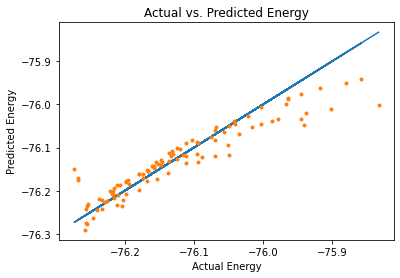

In [19]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt


# Inverse transform the transformed labels
predictions = (predictions * train_labelstd) + train_labelm
test_labels = (test_labels * train_labelstd) + train_labelm


rmse = np.sqrt(mean_squared_error(test_labels, predictions))
print(f'RMSE: {rmse}')

mse = np.sqrt(mean_absolute_error(test_labels, predictions))
print(f'MSE: {mse}')

r2 = r2_score(test_labels, predictions)
print("R-squared (R2) Score:", r2)


""" plt.scatter(test_labels, predictions) """
plt.plot(test_labels, test_labels, "-")
plt.plot(test_labels, predictions, ".")
plt.xlabel('Actual Energy')
plt.ylabel('Predicted Energy')
plt.title('Actual vs. Predicted Energy')
plt.show()